Found 22500 images belonging to 2 classes.
704/704 [==============================] - 15s 22ms/step
predict time: 16.626681566238403 sec
Trainable Parameters：2,431,872
Accuracy: 90.30%
Classification Report:
              precision    recall  f1-score   support

        D000     0.9098    0.9261    0.9179     13175
        D001     0.8928    0.8703    0.8815      9325

    accuracy                         0.9030     22500
   macro avg     0.9013    0.8982    0.8997     22500
weighted avg     0.9028    0.9030    0.9028     22500

Specificity: 92.61%
Top-1 Error: 9.70%
Confusion Matrix:
[[12201   974]
 [ 1209  8116]]


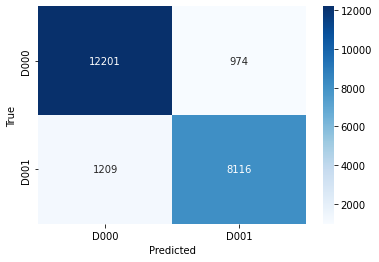

In [3]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, activations, utils, models, callbacks
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import time
from keras.utils.layer_utils import count_params


def squash(x, axis=-1):
    s_squared_norm = tf.reduce_sum(
        tf.square(x), axis, keepdims=True) + tf.keras.backend.epsilon()
    scale = tf.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


def softmax(x, axis=-1):
    ex = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
    return ex / tf.reduce_sum(ex, axis=axis, keepdims=True)


def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return tf.reduce_sum(y_true * tf.square(tf.keras.backend.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * tf.square(tf.keras.backend.relu(y_pred - margin)), axis=-1)

class Capsule(layers.Layer):

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):

        if self.share_weights:
            hat_inputs = tf.keras.backend.conv1d(inputs, self.kernel)
        else:
            hat_inputs = tf.keras.backend.local_conv1d(
                inputs, self.kernel, [1], [1])

        batch_size = tf.shape(inputs)[0]
        input_num_capsule = tf.shape(inputs)[1]
        hat_inputs = tf.reshape(hat_inputs,
                                (batch_size, input_num_capsule,
                                 self.num_capsule, self.dim_capsule))
        hat_inputs = tf.transpose(hat_inputs, (0, 2, 1, 3))

        b = tf.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(
                tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
                if tf.keras.backend.backend() == 'theano':
                    o = tf.reduce_sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Capsule, self).get_config()
        config.update({'num_capsule': self.num_capsule,
                       'dim_capsule': self.dim_capsule,
                       'routings': self.routings,
                       'share_weights': self.share_weights,
                       'activation': activations.serialize(self.activation)})
        return config


def add_commas(num):
    num_str = str(num)
    if len(num_str) <= 3:
        return num_str
    else:
        return add_commas(num_str[:-3]) + ',' + num_str[-3:]


def specificity_score(y_true, y_pred, labels=None, pos_label=1, average='binary'):
    """
    Compute the specificity score.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()
    if average == 'micro':
        specificity = tn / (tn + fp)
    elif average == 'macro':
        specificity = (tn / (tn + fp) + tp / (tp + fn)) / 2
    elif average == 'weighted':
        specificity = (tn / (tn + fp) * (tn + fn) + tp / (tp + fn) * (fp + tp)) / (tn + fp + fn + tp)
    elif average == 'binary':
        specificity = tn / (tn + fp)
    else:
        raise ValueError("Unsupported average type.")
    return specificity


batch_size = 32
num_classes = 2
epochs = 100
DATASET_PATH = './'
IMAGE_SIZE = (32, 32)
BATCH_SIZE = batch_size
NUM_EPOCHS = epochs

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                            target_size=IMAGE_SIZE,
                                            interpolation='bicubic',
                                            class_mode='categorical',
                                            shuffle=False,
                                            batch_size=BATCH_SIZE)
predict_start = time.time()
model = models.load_model('model-capsnet-origin2v1-128D-2-size-100-no-da-final-r2.h5', 
                          custom_objects={'Capsule': Capsule, 'margin_loss': margin_loss})
model.load_weights('weights-capsnet-origin2v1-128D-2-size-100-no-da-final-r2-66.h5')
# 評估模型
y_pred = model.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_set.classes
class_names = list(test_set.class_indices.keys())
predict_end = time.time()
print('predict time: %s sec' % (predict_end - predict_start))

# 顯示模型訓練參數
print("Trainable Parameters：%s" % add_commas(count_params(model.trainable_weights)))

# 計算模型準確率
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# 顯示分類報告
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
# result_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

specificity = specificity_score(y_true, y_pred)
print('Specificity: {:.2f}%'.format(specificity * 100))
top1_errors = 1 - np.mean(y_true == y_pred)
print('Top-1 Error: {:.2f}%'.format(top1_errors * 100))

# 顯示混淆矩陣
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# 绘制 confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()